<a href="https://colab.research.google.com/github/Hennakhan/Detecting-Islamophobia/blob/master/mBert_Trans_Hindi_Unbalanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
1.7812068460000035
GPU (s):
0.04873828600000252
GPU speedup over CPU: 36x


# Islamophhobia Detection with BERT using Keras and TensorFlow 2

In [ ]:
!nvidia-smi

Mon Oct 19 19:34:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    39W / 300W |   1951MiB / 16130MiB |     10%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install tensorflow-gpu 

     |████████████████████████████████| 320.4MB 43kB/s 


In [ ]:
!pip install --upgrade grpcio

Requirement already up-to-date: grpcio in /usr/local/lib/python3.6/dist-packages (1.32.0)


In [ ]:
!pip install tqdm

In [ ]:
!pip install bert-for-tf2

     |████████████████████████████████| 40kB 3.7MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.6-cp36-none-any.whl size=30318 sha256=d6472c4d169698ce7294fe9b51ebf75d5f8a573a27de18bd7c963487d1d2a9a1
  Stored in directory: /root/.cache/pip/wheels/07/a0/b4/75b0601ebaa41e517a797fe9cea119c789664c8408f8a74ae9
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7304 sha256=d434d14f829fea2b405657531fc712316eca7350e7ca4c4152b089b0418493ed
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19475 sha256=e57b79350d6539a6f05d6dfc9a389e66ea0491e5dce963413c91f8d39feee7be
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [ ]:
!pip install googletrans

     |████████████████████████████████| 61kB 5.4MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 972kB 17.3MB/s 
     |████████████████████████████████| 71kB 9.7MB/s 
     |████████████████████████████████| 61kB 8.4MB/s 
     |████████████████████████████████| 102kB 11.1MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-cp36-none-any.whl size=15736 sha256=7865241dc53a17f5d11539af6c66a61848c7395b5bfb8dd698c4587ef401e6af
  Stored in directory: /root/.cache/pip/wheels/28/1a/a7/eaf4d7a3417a0c65796c547cff4deb6d79c7d14c2abd29273e
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=c8f97d9205bdd7f76ef046c79ee97a50dc3029e5fabbc690ce05ee1e8d944379
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built googletrans contextvars


In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.1MB 9.6MB/s 


In [ ]:
!pip install googletrans

In [ ]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

import re

# translator
import googletrans
from googletrans import Translator

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Data


In [ ]:
# Translated Hindi dataset
!gdown --id 1IFaDhhg0qQDjH7X0BfQDYanoKIDLlW0N --output data-task1.csv

Downloading...
From: https://drive.google.com/uc?id=1IFaDhhg0qQDjH7X0BfQDYanoKIDLlW0N
To: /content/data-task1.csv
100% 1.08M/1.08M [00:00<00:00, 71.6MB/s]


In [ ]:
df = pd.read_csv('data-task1.csv', 
                   delimiter=',')
df.columns = ['Text', 'Label']
df.head(15)
df["Text"] = df["Text"].astype(str)
df["Label"] = df["Label"].astype(str)

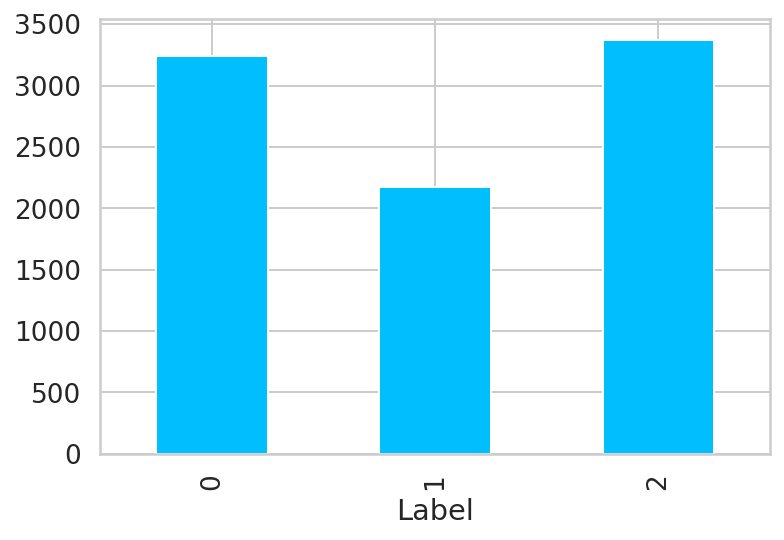

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
df.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [ ]:

# For entire dataset sentences for each labels 
df.Label.value_counts()

2    3374
0    3245
1    2174
Name: Label, dtype: int64

In [ ]:
df=df.sample(frac=1).reset_index(drop=True)
df

,Text,Label
0,'Summa Amen',1
1,'@ RajkumarRatnap2 Agree with you sir. These j...,2
2,'@Munnasaifi @sardanarohit Who set fire in Ben...,2
3,'जो इस्लाम वज़ू में जायदा पानी बहाने का इजाजत...,0
4,"'@ GeoIntel2 meet on Diwali, you will break ha...",0
...,...,...
8788,See how the prince of Ranchi became the king o...,0
8789,'@ZeeNewsHindi' Thousands of Muslims accepted ...,1
8790,'@chandan_m_yadav @ RustamPatel3 @nidhiyadavsp...,0
8791,'@AbdullahJlp Allah Hafiz brother my,1


Data Preprocessing

In [ ]:
df = df[df.Text != '']

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.10, random_state=42)

In [ ]:
df=df.sample(frac=1).reset_index(drop=True)

In [ ]:
df.head()

,Text,Label
0,'@waglenikhil one jihadi can only support anot...,2
1,जेहादी मानसिकता @SumanSh58122278 @kaur_ravindra,2
2,'@ajeetbharti this Diwali should not stop just,0
3,Hindu politicians attending iftar party repres...,2
4,'@ShilpiSinghINC @rahatindori दो कौड़ी का जेहा...,2


# Islamophhobia Detection with BERT


In [ ]:
!gdown --id 1ds0mgIfyRZ1vTdQCT4Q5EOxTFA1vH47a --output multi_cased_L-12_H-768_A-12.zip

Downloading...
From: https://drive.google.com/uc?id=1ds0mgIfyRZ1vTdQCT4Q5EOxTFA1vH47a
To: /content/multi_cased_L-12_H-768_A-12.zip
663MB [00:08, 75.0MB/s]


In [ ]:
!unzip multi_cased_L-12_H-768_A-12

Archive:  multi_cased_L-12_H-768_A-12.zip
   creating: multi_cased_L-12_H-768_A-12/
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: multi_cased_L-12_H-768_A-12/vocab.txt  
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: multi_cased_L-12_H-768_A-12/bert_config.json  


In [ ]:
os.makedirs("model", exist_ok=True)

In [ ]:
!mv multi_cased_L-12_H-768_A-12/ model

In [ ]:
bert_model_name="multi_cased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

## Preprocessing

In [ ]:
class IslamophobiaDetectionData:
  DATA_COLUMN = "Text"
  LABEL_COLUMN = "Label"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[IslamophobiaDetectionData.DATA_COLUMN], row[IslamophobiaDetectionData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [ ]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [ ]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  #print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)

  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)


  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
  
  model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)
        
  return model

## Training

In [ ]:
classes = train.Label.unique().tolist()

data = IslamophobiaDetectionData(train, test, tokenizer, classes, max_seq_len=128)

7913it [00:04, 1967.67it/s]
880it [00:00, 2229.21it/s]


max seq_len 171


In [ ]:
model = create_model(data.max_seq_len, bert_ckpt_file)

Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f4a134a6898> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 128)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 128, 768)          177261312 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                

In [ ]:
history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=5
)

Epoch 1/5
446/446 [==============================] - 235s 527ms/step - loss: 0.8370 - acc: 0.6911 - val_loss: 0.6228 - val_acc: 0.9280
Epoch 2/5
446/446 [==============================] - 225s 504ms/step - loss: 0.6257 - acc: 0.9242 - val_loss: 0.6188 - val_acc: 0.9318
Epoch 3/5
446/446 [==============================] - 225s 504ms/step - loss: 0.6065 - acc: 0.9444 - val_loss: 0.6225 - val_acc: 0.9280
Epoch 4/5
446/446 [==============================] - 222s 497ms/step - loss: 0.6034 - acc: 0.9473 - val_loss: 0.6216 - val_acc: 0.9293
Epoch 5/5
446/446 [==============================] - 220s 494ms/step - loss: 0.6006 - acc: 0.9496 - val_loss: 0.6185 - val_acc: 0.9331


## Evaluation

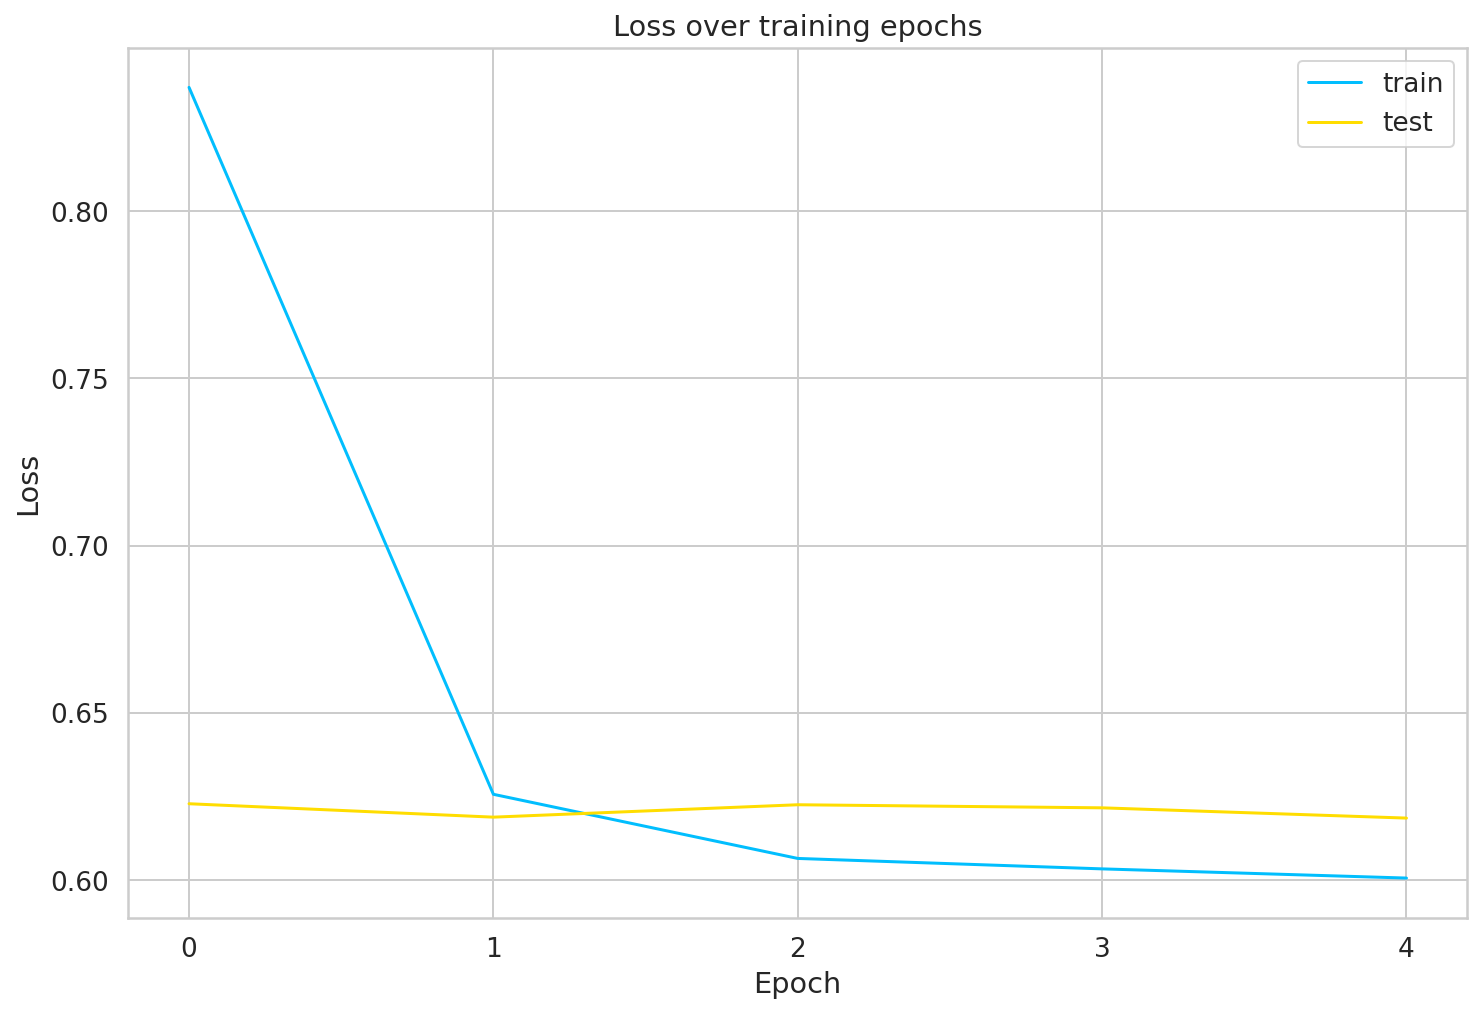

In [ ]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

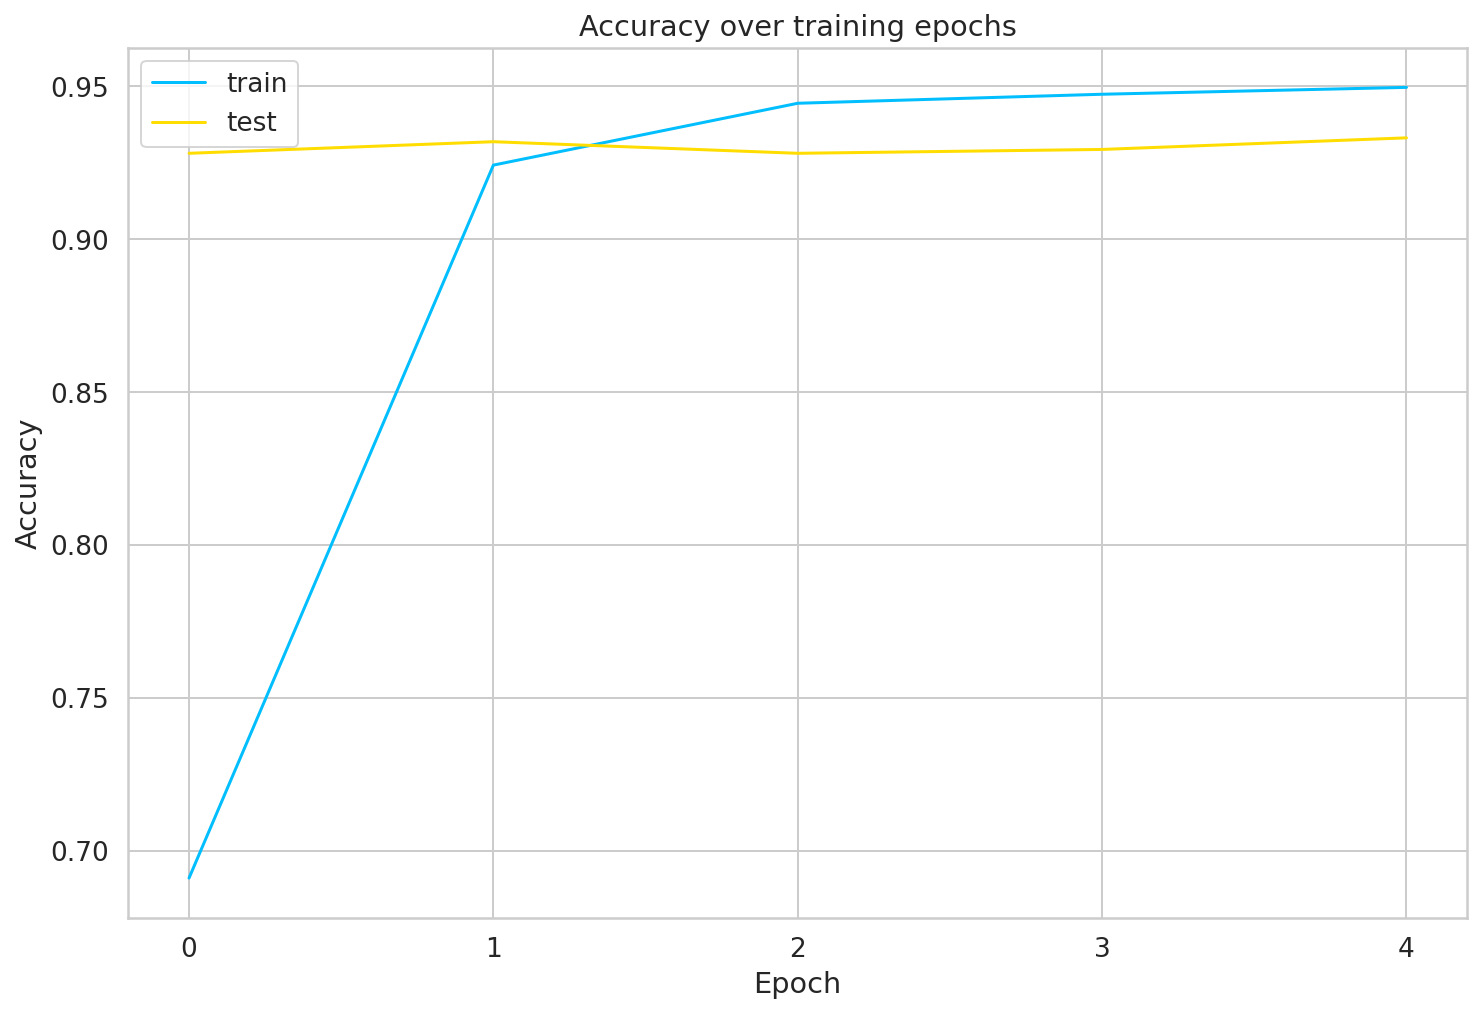

In [ ]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();

In [ ]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

28/28 [==============================] - 3s 103ms/step - loss: 0.6075 - acc: 0.9409
train acc 0.9619613289833069
test acc 0.9409090876579285


In [ ]:
y_pred = model.predict(data.test_x).argmax(axis=-1)

In [ ]:
print(classification_report(data.test_y, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       326
           1       0.96      0.93      0.94       337
           2       0.91      0.93      0.92       217

    accuracy                           0.94       880
   macro avg       0.94      0.94      0.94       880
weighted avg       0.94      0.94      0.94       880



In [ ]:

cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

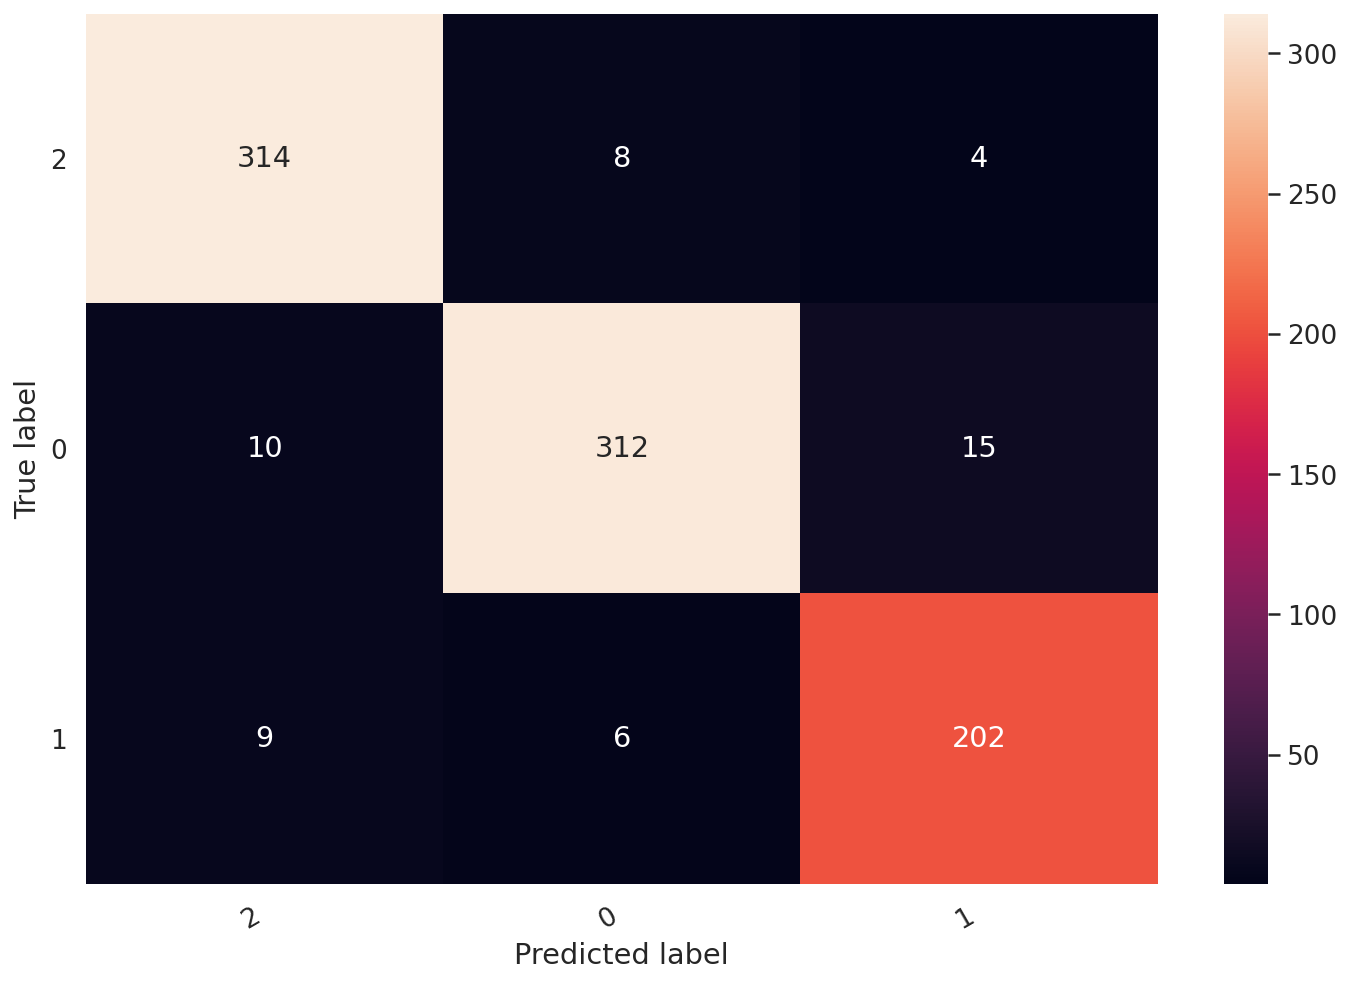

In [ ]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

# 10 Fold cross validation

In [ ]:
import random
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

kFold = 10

#To get accuracy of the model for 10 different splits
scores = []
training_accuracy = []
testing_accuracy = []
print("BERT: ")
for i in range(kFold):
    print('Fold ', i+1)
    print('')
    # Splitting data into test and train
    train, test = train_test_split(df, test_size=0.10, shuffle = True)

    classes = train.Label.unique().tolist()
    data = IslamophobiaDetectionData(train, test, tokenizer, classes, max_seq_len=128)
    model = create_model(data.max_seq_len, bert_ckpt_file)
    history = model.fit( x=data.train_x, y=data.train_y,validation_split=0.1,batch_size=16, shuffle=True,epochs=5)
    #train_loss, train_acc = model.evaluate(data.train_x, data.train_y)
    test_loss, test_acc = model.evaluate(data.test_x, data.test_y)
    
    #training_accuracy.append(train_acc)
    testing_accuracy.append(test_acc)

    y_pred = model.predict(data.test_x).argmax(axis=-1)

    scoreValue =accuracy_score(data.test_y, y_pred)
    scores.append(scoreValue)


215it [00:00, 2140.74it/s]

BERT: 
Fold  1



7913it [00:03, 2200.01it/s]
880it [00:00, 2196.83it/s]


max seq_len 171
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f484d64e048> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
446/446 [==============================] - 219s 492ms/step - loss: 0.8006 - acc: 0.7368 - val_loss: 0.6288 - val_acc: 0.9217
Epoch 2/5
446/446 [==============================] - 222s 498ms/step - loss: 0.6270 - acc: 0.9233 - val_loss: 0.6374 - val_acc: 0.9116
Epoch 3/5
446/446 [==============================] - 215s 483ms/step - 

223it [00:00, 2217.86it/s]

Fold  2



7913it [00:03, 2199.54it/s]
880it [00:00, 2181.89it/s]


max seq_len 171
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f4844d85b70> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
446/446 [==============================] - 225s 505ms/step - loss: 0.7836 - acc: 0.7516 - val_loss: 0.6302 - val_acc: 0.9205
Epoch 2/5
446/446 [==============================] - 210s 470ms/step - loss: 0.6231 - acc: 0.9281 - val_loss: 0.6170 - val_acc: 0.9331
Epoch 3/5
446/446 [==============================] - 209s 468ms/step - 

213it [00:00, 2124.87it/s]

Fold  3



7913it [00:03, 2195.10it/s]
880it [00:00, 2167.43it/s]


max seq_len 171
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f4a0eb195c0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
446/446 [==============================] - 212s 476ms/step - loss: 0.7975 - acc: 0.7318 - val_loss: 0.6367 - val_acc: 0.9116
Epoch 2/5
446/446 [==============================] - 207s 464ms/step - loss: 0.6221 - acc: 0.9282 - val_loss: 0.6150 - val_acc: 0.9343
Epoch 3/5
446/446 [==============================] - 204s 458ms/step - 

222it [00:00, 2216.51it/s]

Fold  4



7913it [00:03, 2250.23it/s]
880it [00:00, 2275.13it/s]


max seq_len 171
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f484dd8bda0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
446/446 [==============================] - 207s 464ms/step - loss: 0.9277 - acc: 0.5985 - val_loss: 0.6382 - val_acc: 0.9116
Epoch 2/5
446/446 [==============================] - 204s 459ms/step - loss: 0.6300 - acc: 0.9198 - val_loss: 0.6070 - val_acc: 0.9432
Epoch 3/5
446/446 [==============================] - 204s 458ms/step - 

215it [00:00, 2147.60it/s]

Fold  5



7913it [00:03, 2215.55it/s]
880it [00:00, 2197.45it/s]


max seq_len 171
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f4846af99e8> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
446/446 [==============================] - 207s 464ms/step - loss: 0.9239 - acc: 0.5929 - val_loss: 0.6153 - val_acc: 0.9343
Epoch 2/5
446/446 [==============================] - 203s 456ms/step - loss: 0.6219 - acc: 0.9285 - val_loss: 0.6149 - val_acc: 0.9343
Epoch 3/5
446/446 [==============================] - 202s 453ms/step - 

226it [00:00, 2259.12it/s]

Fold  6



7913it [00:03, 2248.13it/s]
880it [00:00, 2315.65it/s]


max seq_len 171
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f484669f358> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
446/446 [==============================] - 210s 470ms/step - loss: 0.8743 - acc: 0.6527 - val_loss: 0.6410 - val_acc: 0.9116
Epoch 2/5
446/446 [==============================] - 207s 463ms/step - loss: 0.6393 - acc: 0.9115 - val_loss: 0.6367 - val_acc: 0.9154
Epoch 3/5
446/446 [==============================] - 205s 459ms/step - 

232it [00:00, 2314.95it/s]

Fold  7



7913it [00:03, 2304.67it/s]
880it [00:00, 2299.45it/s]


max seq_len 171
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f4a1019ceb8> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
446/446 [==============================] - 209s 469ms/step - loss: 0.8292 - acc: 0.7000 - val_loss: 0.6355 - val_acc: 0.9116
Epoch 2/5
446/446 [==============================] - 206s 461ms/step - loss: 0.6315 - acc: 0.9184 - val_loss: 0.6310 - val_acc: 0.9167
Epoch 3/5
446/446 [==============================] - 206s 461ms/step - 

249it [00:00, 2486.03it/s]

Fold  8



7913it [00:03, 2318.82it/s]
880it [00:00, 2331.45it/s]


max seq_len 171
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f4844f641d0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
446/446 [==============================] - 205s 461ms/step - loss: 0.8486 - acc: 0.6804 - val_loss: 0.6380 - val_acc: 0.9141
Epoch 2/5
446/446 [==============================] - 201s 452ms/step - loss: 0.6277 - acc: 0.9216 - val_loss: 0.6134 - val_acc: 0.9356
Epoch 3/5
446/446 [==============================] - 202s 452ms/step - 

238it [00:00, 2375.23it/s]

Fold  9



7913it [00:03, 2303.51it/s]
880it [00:00, 2277.65it/s]


max seq_len 171
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f484dce8a20> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
446/446 [==============================] - 212s 475ms/step - loss: 1.0045 - acc: 0.5091 - val_loss: 0.8213 - val_acc: 0.7260
Epoch 2/5
446/446 [==============================] - 209s 468ms/step - loss: 0.8526 - acc: 0.6863 - val_loss: 0.8208 - val_acc: 0.7273
Epoch 3/5
446/446 [==============================] - 207s 463ms/step - 

220it [00:00, 2197.75it/s]

Fold  10



7913it [00:03, 2349.03it/s]
880it [00:00, 2396.51it/s]


max seq_len 171
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f4845837d68> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
446/446 [==============================] - 209s 468ms/step - loss: 0.8098 - acc: 0.7284 - val_loss: 0.6138 - val_acc: 0.9369
Epoch 2/5
446/446 [==============================] - 206s 462ms/step - loss: 0.6216 - acc: 0.9291 - val_loss: 0.6060 - val_acc: 0.9457
Epoch 3/5
446/446 [==============================] - 206s 462ms/step - 

In [ ]:

Mean_score = sum(scores) / len(scores)
print(f" Mean predict: {Mean_score}" )

mean_test = sum(testing_accuracy)/len(testing_accuracy)
print(f" Mean testing accuracy for 10 folds: {mean_test}" )

 Mean predict: 0.9372727272727273
 Mean testing accuracy for 10 folds: 0.9372727274894714


In [ ]:
translator = Translator()
sentences = []
# 1
hin_text =  "इसलाम सुंदर है"
print("Hindi: ", hin_text)

trans = translator.translate(hin_text, dest='en')
print()
sentences.append(trans.text)

# 0
hin_text =  " समाज वादी  पार्टी  जिंदाबाद "
print("Hindi: ", hin_text)

trans = translator.translate(hin_text, dest='en')
print()
sentences.append(trans.text)

# 2
hin_text =  "'गाजा में दीवाली   की ढेरो बधाई मित्रो 😊💐  #IsraeliBombing 😂😂"
print("Hindi: ", hin_text)

trans = translator.translate(hin_text, dest='en')
print()
sentences.append(trans.text)

# 2
sentences.append( "Play our song now you asshole jehadi muslim")

# 0
sentences.append( "Rate this book as awful")


pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

for text, label in zip(sentences, predictions):
  print("text:", text, "\nLabel:", classes[label])
  print()

Hindi:  इसलाम सुंदर है

Hindi:   समाज वादी  पार्टी  जिंदाबाद 

Hindi:  'गाजा में दीवाली   की ढेरो बधाई मित्रो 😊💐  #IsraeliBombing 😂😂

text: Islam is beautiful 
Label: 1

text: Samajwadi Party Zindabad 
Label: 0

text: 'Happy Diwali greetings in Gaza Friends 😊💐 #IsraeliBombing 😂😂 
Label: 0

text: Play our song now you asshole jehadi muslim 
Label: 2

text: Rate this book as awful 
Label: 1

